In [ ]:
from collections import defaultdict

import gymnasium
from gymnasium.envs.toy_text.cliffwalking import (
    UP, RIGHT, DOWN, LEFT, POSITION_MAPPING
)
import numpy as np
import tqdm
from IPython import display

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


In [3]:
class CliffWalkingEnv(gymnasium.Wrapper):
    def __init__(self, random_init_state=False, max_episode_steps=1000, 
                 render_mode="rgb_array", **kwargs):
        env = gymnasium.make(
            "CliffWalking-v1",
            max_episode_steps=max_episode_steps,
            render_mode=render_mode,
            **kwargs
        )
        super().__init__(env)

        self.nS = self.env.get_wrapper_attr('nS')
        self.nA = self.env.get_wrapper_attr('nA')
        self.shape = self.env.get_wrapper_attr('shape')

        # The original transition probabilities for absorbing states are not correct.
        P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(self.nA)}
            P[s][UP] = self._calculate_transition_prob(position, UP)
            P[s][RIGHT] = self._calculate_transition_prob(position, RIGHT)
            P[s][DOWN] = self._calculate_transition_prob(position, DOWN)
            P[s][LEFT] = self._calculate_transition_prob(position, LEFT)
        self.env.set_wrapper_attr('P', P)

        if random_init_state:
            initial_state_distrib = np.ones(self.nS)
            cliff_positions = np.asarray(np.where(env.get_wrapper_attr('_cliff')))
            cliff_states = np.ravel_multi_index(cliff_positions, self.shape)
            initial_state_distrib[cliff_states] = 0.0
            initial_state_distrib[47] = 0.0
            initial_state_distrib /= np.sum(initial_state_distrib, keepdims=True)
            self.env.set_wrapper_attr('initial_state_distrib', initial_state_distrib)

        # Calculate transition probabilities and rewards
        rewards = np.full((self.nS, self.nA, self.nS), np.nan)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))
        for state in range(self.nS):
            for action in range(self.nA):
                _, next_state, reward, terminated = self.env.get_wrapper_attr('P')[state][action][0]
                rewards[state, action, next_state] = reward
                transition_probs[state, action, next_state] += 1.0
                masks[state, action, next_state] = float(not terminated)
        transition_probs /= np.sum(transition_probs, axis=-1, keepdims=True)
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)
        reward_max, reward_min = np.nanmax(rewards), np.nanmin(rewards)
        rewards[np.isnan(rewards)] = reward_min
        assert np.all((reward_min <= rewards) & (rewards <= reward_max))

        self._orig_reward_min, self._orig_reward_max = reward_min, reward_max
        self.orig_rewards = rewards
        self.rewards = (rewards - reward_min) / (reward_max - reward_min)
        self.transition_probs = transition_probs
        self.masks = masks

    def _calculate_transition_prob(self, current, move):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        
        The original transition probabilities for absorbing states are not correct.
        """
        if not self.env.get_wrapper_attr('is_slippery'):
            deltas = [POSITION_MAPPING[move]]
        else:
            deltas = [
                POSITION_MAPPING[act] for act in [(move - 1) % 4, move, (move + 1) % 4]
            ]
        outcomes = []

        # the single absorbing state is the goal
        goal_position = np.asarray([self.shape[0] - 1, self.shape[1] - 1])
        goal_state = np.ravel_multi_index(goal_position, self.shape)
        current_position = np.array(current)
        current_state = np.ravel_multi_index(tuple(current_position), self.shape)
        for delta in deltas:
            if current_state == goal_state:
                new_state = current_state
                reward = 0
                is_terminated = True
            else:
                new_position = current_position + np.array(delta)
                new_position = self.env.get_wrapper_attr('_limit_coordinates')(new_position).astype(int)
                new_state = np.ravel_multi_index(tuple(new_position), self.shape)
                if self.env.get_wrapper_attr('_cliff')[tuple(new_position)]:
                    reward = -100
                    new_state = self.env.get_wrapper_attr('start_state_index')
                else:
                    reward = -1
                is_terminated = (new_state == goal_state)
            outcomes.append((1 / len(deltas), new_state, reward, is_terminated))
        return outcomes

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.env.set_wrapper_attr('start_state_index', obs)

        return obs, info

    def step(self, action):
        obs, orig_reward, terminated, truncated, info = super().step(action)
        reward = (orig_reward - self._orig_reward_min) / (self._orig_reward_max - self._orig_reward_min)

        return obs, reward, terminated, truncated, info


In [4]:
# collect dataset
discount = 0.95
max_episode_steps = 100
env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.nS, env.nA]) / env.nA

dataset = defaultdict(list)

num_episodes = 1000
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    obs, info = env.reset()
    for _ in range(max_episode_steps):
        action = np.random.choice(np.arange(env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['next_observations'].append(next_obs)
        dataset['masks'].append(not terminated)  # for absorbing states
        dataset['terminals'].append(truncated)  # for the end of trajectories
        
        obs = next_obs

for k, v in dataset.items():
    if k in ['observations', 'actions', 'next_observations']:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

print("num of total transitions {}".format(num_transitions))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 332.21it/s]

num of total transitions 100000


#### Utils

In [5]:
(terminal_locs,) = np.nonzero(dataset['terminals'] > 0)
assert terminal_locs[-1] == (len(dataset['observations']) - 1)

def sample_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)
    
    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], dataset['observations'])
    if relabel_reward:
        successes = np.logical_or((idxs + 1) == goal_idxs, idxs == goal_idxs).astype(float)
        batch['masks'] = 1.0 - successes
        batch['rewards'] = successes - 1.0  # 0 for goal and -1 for other states
    
    return batch

In [6]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### CRL + BNCE

In [8]:
goal_marg = np.zeros(env.nS)
for state in range(env.nS):
    goal_marg[state] = np.sum(dataset['next_observations'] == state) / len(dataset['next_observations'])
goal_marg = jnp.asarray(goal_marg)
print(goal_marg)


[0.0586  0.0464  0.03364 0.02473 0.0179  0.01305 0.0097  0.00923 0.00904
 0.00765 0.00698 0.00679 0.07411 0.04839 0.03141 0.02082 0.01415 0.01031
 0.00824 0.00765 0.00652 0.00584 0.00587 0.00607 0.11193 0.04455 0.02187
 0.01248 0.00786 0.00616 0.00481 0.00424 0.00375 0.00353 0.00315 0.0031
 0.22142 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.06806]


In [14]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    future_obs = jax.nn.one_hot(future_obs, env.nS)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

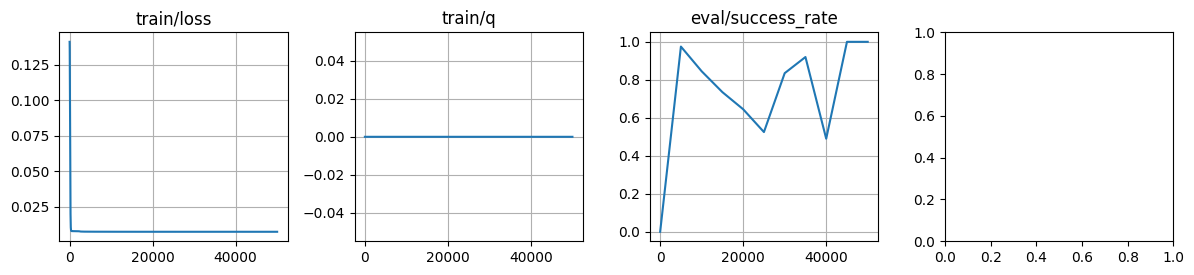

100%|██████████| 50000/50000 [01:47<00:00, 467.00it/s]


In [15]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2, p_curgoal=0.0, p_trajgoal=1.0)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])

def loss_fn(params, batch):
  pos_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'])
  neg_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  I = jnp.eye(batch_size)
  logits = I * pos_logits + (1 - I) * neg_logits
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=I).mean()
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             jnp.full_like(batch['observations'], (env.nS - 2)))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[env.nS - 2]
  q = (1 + discount) * plus_probs
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, opt_state, batch):
  (loss, info), grads = grad_fn(params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  return params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=200, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(eval_env.nS)[:, None].repeat(eval_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(eval_env.nA)[None, :].repeat(eval_env.nS, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             jnp.full_like(obs, (eval_env.nS - 1)))
  plus_logits = jnp.diag(plus_logits)
  plus_logits = plus_logits.reshape([eval_env.nS, eval_env.nA])
  a = jnp.argmax(plus_logits, axis=-1)
  pi = jax.nn.one_hot(a, eval_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  return sr

def evaluate_fn(params):
  sr = compute_success_rate(params)
  
  info = {
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size, p_curgoal=0.0, p_trajgoal=1.0)
  critic_params, opt_state, loss, info = update_fn(
    critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [16]:
crl_metrics = metrics
print(crl_metrics['eval/success_rate'][-1])

[5.e+04 1.e+00]
